In [ ]:
import numpy as np
import pandas as pd
import lib
import os

pwd = os.getcwd()
# load ravdess.npy , savee.npy and tess.npy
ravdess_data = np.load('ravdess.npy')
savee_data = np.load('savee.npy') 
tess_data = np.load('tess.npy')
crema_data = np.load('crema.npy')

# ravdess_data.shape, savee_data.shape, tess_data.shape
all_data = np.vstack((ravdess_data, savee_data, tess_data, crema_data))
df = pd.DataFrame(all_data, columns=['label', 'gender', 'pathname', 'filename'])
df.head(), df.shape

# save all data into npy file
np.save("all_datasets.npy", df)

In [ ]:
import matplotlib.pyplot as plt
def plot_spec(Y_scale, sr, hop_size, y_axis):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y_scale, sr=sr, hop_length=hop_size, x_axis='time', y_axis= y_axis)
    plt.colorbar(format='%+2.0f dB')

In [10]:
# load wav files using the 'pathname' and 'filename' columns of all_data with librosa
import librosa
import librosa.display
# import ipy previewer
import IPython.display as ipd

frame_size = 4096  # in samples
hop_size = 1024  # in samples
temporal_chunk_size = 20  # number of temporal bins per sample
mel_bands = 128  # number of mel bands
silence_threshold = 40  # in  relative to peak dB

# total temporal bins is total_samples/hop_size

data = []

for sample_index in range(20):
    stft_temporal_chunks = []

    pathname = df['pathname'][sample_index]
    filename = df['filename'][sample_index]

    wav, sr = librosa.load(pwd + pathname + filename)
    trimmed_wav, _ = librosa.effects.trim(wav, top_db=silence_threshold)

    if sr != 22050:
        raise ValueError("Sample rate is not 22050Hz")

    # extract stft of the trimmed wav
    S_audio = librosa.stft(trimmed_wav, n_fft=frame_size, hop_length=hop_size)
    y_audio = librosa.power_to_db(np.abs(S_audio))

    # split y into chunks of size temporal_chunk_size.
    _y = (y_audio).T

    split_indices = np.unique([(i, len(_y) - temporal_chunk_size)[int(
        i + temporal_chunk_size >= len(_y))]for i in range(0, len(_y), temporal_chunk_size)])

    # librosa.display.specshow(
    #     _y[:temporal_chunk_size].T, sr=sr, hop_length=hop_size, x_axis='time', y_axis='log')
    # plt.show()

    # extract the mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=trimmed_wav, sr=sr, n_fft=frame_size, hop_length=hop_size, n_mels=mel_bands)
    log_mel_spec = librosa.power_to_db(mel_spec)
    _mel_spec = (log_mel_spec).T

    # to include mel-spec add `_mel_spec[i:i+temporal_chunk_size].T` in the list
    [stft_temporal_chunks.append(
        [_y[i:i+temporal_chunk_size].T, _mel_spec[i:i+temporal_chunk_size].T, df['gender'][sample_index], df['label'][sample_index]])
     for i in split_indices]

    # librosa.display.waveshow(trimmed_wav, sr=sr)

    [data.append(c) for c in stft_temporal_chunks]


(10,)


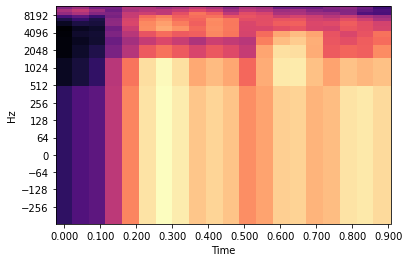

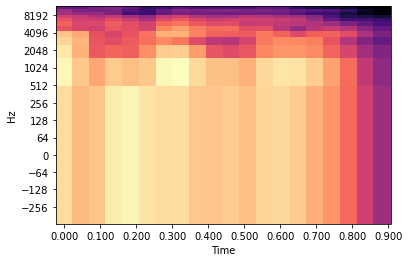

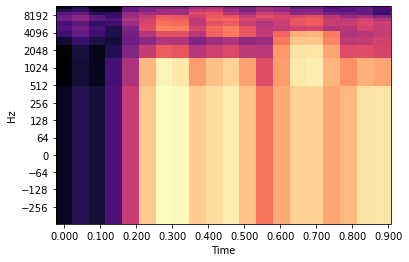

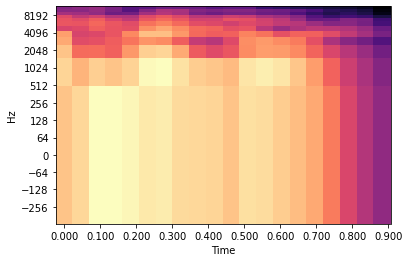

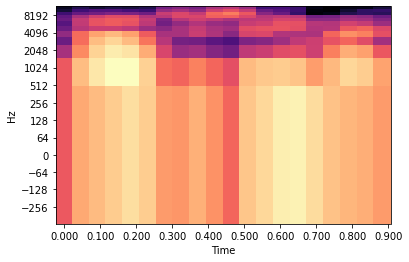

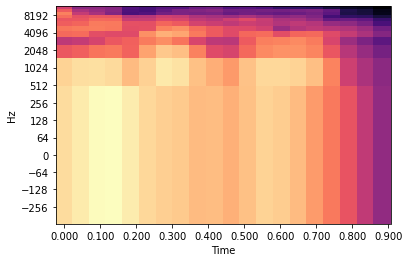

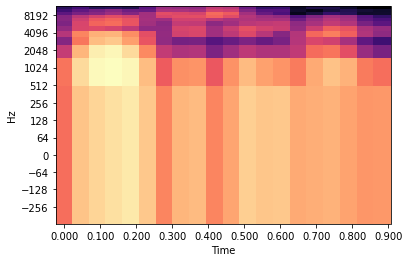

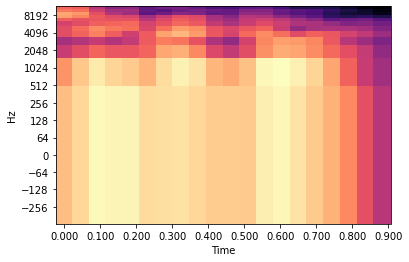

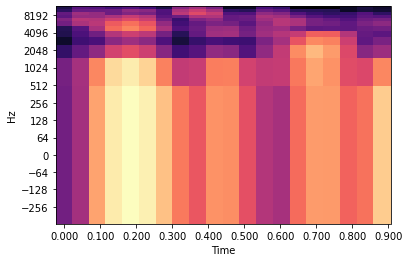

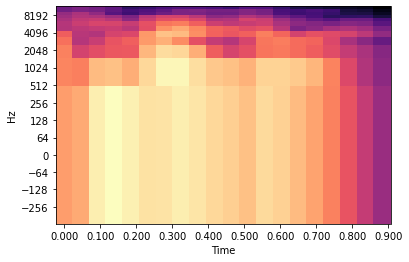

In [11]:
# data = np.array(data) 
processed_dataset = pd.DataFrame(data, columns=['stft_data', 'mel_data','gender', 'label'])

#plot the stft at index 0 of processed_dataset
stfts = processed_dataset['mel_data'][:10]
print(stfts.shape)
for stft in stfts:
    librosa.display.specshow(stft, sr=sr, hop_length=hop_size, x_axis='time', y_axis='log')
    plt.show()